In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from IPython.display import clear_output

In [2]:
#Function that helps print pictures
def print_pic(pic):
    plt.imshow(pic)
    plt.show()

In [3]:
#Function that finds firs white pixel in the mask "arr" in direction set by the "koef"
def first_white(arr, koef):
    pnt = None
    tmp =  np.flatnonzero(arr)
    if (len(tmp) > 0):
        if koef:
            pnt = tmp[-1]
        else:
            pnt = tmp[0]
        
    return pnt

In [4]:
#Interpolation of boarder points
#1
mask_obj = cv2.imread("ObjectMask.PNG", cv2.IMREAD_GRAYSCALE)

array2 = np.apply_along_axis(first_white, axis=1, arr=mask_obj, koef = 1)
array1 = np.array([i for i in range(mask_obj.shape[0])])

array1 = array1[array2 != None]
array2 = array2[array2 != None]

a1, a2 = np.polyfit(array1.astype('float')[20:-20], array2.astype('float')[20:-20], 1)

#2
array2 = np.apply_along_axis(first_white, axis=1, arr=mask_obj, koef = 0)
array1 = np.array([i for i in range(mask_obj.shape[0])])

array1 = array1[array2 != None]
array2 = array2[array2 != None]

b1, b2 = np.polyfit(array1.astype('float')[20:-20], array2.astype('float')[20:-20], 1)

#3
array1 = np.apply_along_axis(first_white, axis=0, arr=mask_obj, koef = 1)
array2 = np.array([i for i in range(mask_obj.shape[1])])

array2 = array2[array1 != None]
array1 = array1[array1 != None]

c1, c2 = np.polyfit(array2.astype('float')[20:-20], array1.astype('float')[20:-20], 1)

#4
array1 = np.apply_along_axis(first_white, axis=0, arr=mask_obj, koef = 0)
array2 = np.array([i for i in range(mask_obj.shape[1])])

array2 = array2[array1 != None]
array1 = array1[array1 != None]

d1, d2 = np.polyfit(array2.astype('float')[20:-20], array1.astype('float')[20:-20], 1)


In [5]:
#Finding intersection points - edge points of the book. 
x1 = (c1*a2+c2)/(1 - a1*c1)
y1 = a1*x1+a2
print(x1, y1) #bottom right

x2 = (d1*a2+d2)/(1 - a1*d1)
y2 = a1*x2+a2
print(x2, y2) #top right

x3 = (c1*b2+c2)/(1 - b1*c1)
y3 = b1*x3+b2
print(x3, y3) #bottom left

x4 = (d1*b2+d2)/(1 - b1*d1)
y4 = b1*x4+b2
print(x4, y4) #top left

h = math.ceil(max(y1, y2) - min(y3, y4))
w = math.ceil(max(x1, x2) - min(x3, x4))
print(h,w)

408.36424358380725 475.6454434668965
27.000000000000018 459.39333484657766
406.63245053650917 190.47685501182698
27.0 195.54138895194063
286 382


In [6]:
#Function that crops the book cover and removes its perspective deformation. It does the same with the augmented layer and the masks of both objects. 

def crop_pic(pic, h, w, x1, y1, x2, y2, x3, y3, x4, y4):
    dst = np.array([[0.,0.], [h, 0.], [h, w],[0., w]], dtype="float32")
    rect = np.array([[y4, x4], [y2,x2], [y1,x1],[y3,x3]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(pic, M, (286, 380))

    return warped

In [7]:
#Function that changes the dimensions of arbitrary 2D layer
def crop_pic_crop(pic, h, w):
    dst = np.array([[0.,0.], [h, 0.], [h, w],[0., w]], dtype="float32")
    rect = np.array([[0., 0.], [pic.shape[1], 0.], [pic.shape[1], pic.shape[0]],[0.,pic.shape[0]]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(pic, M, (286, 380))

    return warped

In [8]:
#Importing pictures
frame0 = cv2.imread("ReferenceFrame.png")
lay = cv2.imread("AugmentedLayer.PNG")
mask_lay = cv2.imread("AugmentedLayerMask.PNG")


In [9]:
cr_frame0 = crop_pic(frame0, h, w, x1, y1, x2, y2, x3, y3, x4, y4)
cr_lay = crop_pic(lay, h, w, x1, y1, x2, y2, x3, y3, x4, y4)
cr_mask_lay = crop_pic(mask_lay, h, w, x1, y1, x2, y2, x3, y3, x4, y4)


In [10]:
#Function that finds the book in a current frame and applies augmented layer on it
def apply_lay(cur_frame, cr_frame0, cr_lay, cr_mask_lay):
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp_query = sift.detect(cr_frame0)
    kp_train = sift.detect(cur_frame)
    kp_query, des_query = sift.compute(cr_frame0, kp_query)
    kp_train, des_train = sift.compute(cur_frame, kp_train)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query,des_train,k=2)
    good = []
    
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 10
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        h,w,t = cr_frame0.shape
        h_t, w_t, t = cur_frame.shape

        warped = cv2.warpPerspective(cr_lay, M, (w_t, h_t))
        warp_mask = cv2.warpPerspective(cr_mask_lay, M, (w_t, h_t))
        warped_orig = cv2.warpPerspective(cr_frame0, M, (w_t, h_t))
        
        warp_mask = np.not_equal(warp_mask, [255,255,255])
        warped[warp_mask] = cur_frame[warp_mask]
        
        warp_mask = np.invert(warp_mask)
        
        warped_orig[warped_orig == 0] = 1
        cur_frame[cur_frame == 0] = 1
        warped[warped == 0] = 1
        
        warped_tmp = warped.astype(np.float32)
        warped_tmp[warp_mask] = (warped_tmp[warp_mask]*(cur_frame[warp_mask]).astype(np.float32))/((warped_orig[warp_mask]).astype(np.float32))
        warped_tmp[warped_tmp > 254.] = 254.
        warped_tmp = warped_tmp.astype(np.uint8)
        
        warped[warped < 250] = warped_tmp[warped < 250]

        return warped

    else:
        print("ERROR")
        return None

In [11]:
#Video function. Changes frames in the process of playing video and saving it 
def play_video(video_path):
    cap = cv2.VideoCapture(video_path)
    
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    out = cv2.VideoWriter('output.avi', fourcc, fps, (w,  h))

    try:
        while(True):
            ret, frame = cap.read()
            
            if not ret or frame is None:
                cap.release()
                out.release()
                print("Released Video Resource")
                break            
            
            frame = apply_lay(frame, cr_frame0, cr_lay, cr_mask_lay)
            
            plt.axis('off')
            plt.imshow(frame[:,:,::-1])
            plt.show()
            
            out.write(frame)
            
            clear_output(wait=True)
            
    except KeyboardInterrupt:
        cap.release()
        out.release()
        print("Released Video Resource")



In [12]:
#Main
play_video('Video.avi') 

Released Video Resource


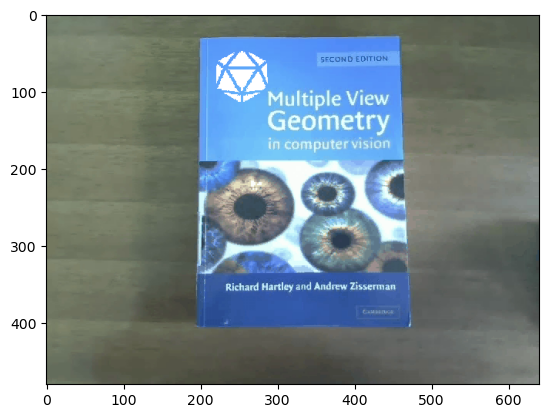

In [13]:
#Possibility to add any other 2D layer on top of the book

lay = cv2.imread("pic.jpeg")
mask_lay = cv2.imread("mask.jpeg")
cr_lay = crop_pic_crop(lay, h, w)
cr_mask_lay = crop_pic_crop(mask_lay, h, w)

print_pic(apply_lay(frame0, cr_frame0, cr_lay, cr_mask_lay)[:,:,::-1])